# ** IMPORT PACKAGES: **

In [1]:
# python peripherals
import os
import random
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

# scipy
import scipy.io
import scipy.stats as ss

# numpy
import numpy

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.ticker as ticker

# pytorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

# ipython
from IPython.display import display, HTML

# deep signature
from deep_signature.utils import utils
from deep_signature.data_generation.curve_generation import LevelCurvesGenerator
from deep_signature.data_manipulation import curve_processing
from deep_signature.nn.datasets import DeepSignatureTupletsDataset
from deep_signature.nn.networks import DeepSignatureArcLengthNet
from deep_signature.nn.losses import ContrastiveLoss
from deep_signature.nn.trainers import ModelTrainer
from deep_signature.data_manipulation import curve_sampling
from deep_signature.data_manipulation import curve_processing

# common
from common import settings


# ** HELPER FUNCTIONS: **

In [2]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

# https://stackoverflow.com/questions/36074455/python-matplotlib-with-a-line-color-gradient-and-colorbar
def colorline(ax, x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = numpy.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = numpy.array([z])

    z = numpy.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    # ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = numpy.array([x, y]).T.reshape(-1, 1, 2)
    segments = numpy.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def plot_dist(ax, dist):
    x = numpy.array(range(dist.shape[0]))
    y = dist
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    colorline(ax=ax, x=x, y=y, cmap='hsv')

def plot_curve_sample(ax, curve, curve_sample, indices, zorder, point_size=10, alpha=1, cmap='hsv'):
    x = curve_sample[:, 0]
    y = curve_sample[:, 1]
    c = numpy.linspace(0.0, 1.0, curve.shape[0])

    ax.scatter(
        x=x,
        y=y,
        c=c[indices],
        s=point_size,
        cmap=cmap,
        alpha=alpha,
        norm=plt.Normalize(0.0, 1.0),
        zorder=zorder)

def plot_curve_section_center_point(ax, x, y, zorder, radius=1, color='white'):
    circle = plt.Circle((x, y), radius=radius, color=color, zorder=zorder)
    ax.add_artist(circle)

def plot_curve(ax, curve, linewidth=2, color='red', alpha=1):
    x = curve[:, 0]
    y = curve[:, 1]
    ax.plot(x, y, linewidth=linewidth, color=color, alpha=alpha)

def plot_curvature(ax, curvature, color='red', linewidth=2):
    x = range(curvature.shape[0])
    y = curvature
    ax.plot(x, y, color=color, linewidth=linewidth)

def plot_sample(ax, sample, color, zorder, point_size=10, alpha=1):
    x = sample[:, 0]
    y = sample[:, 1]

    ax.scatter(
        x=x,
        y=y,
        s=point_size,
        color=color,
        alpha=alpha,
        zorder=zorder)

def all_subdirs_of(b='.'):
  result = []
  for d in os.listdir(b):
    bd = os.path.join(b, d)
    if os.path.isdir(bd): result.append(bd)
  return result

# ** GLOBAL SETTINGS: **

In [3]:
plt.style.use("dark_background")

# ** SANITY CHECK - CURVES: **

In [ ]:
curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
limit = 10
color_map = plt.get_cmap('rainbow', limit)
for i, curve in enumerate(curves[:limit]): 
    fig, ax = plt.subplots(1, 1, figsize=(80,40))
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(30)
    ax.axis('equal')
    plot_curve(ax=ax, curve=curve, linewidth=5)
    plt.show()

# ** SANITY CHECK - DATASET PAIRS **

In [ ]:
dataset = DeepSignatureTupletsDataset()
dataset.load_dataset(dir_path=settings.level_curves_arclength_tuplets_dir_path)
dataset_size = len(dataset)
indices = list(range(dataset_size))
numpy.random.shuffle(indices)
sampler = SubsetRandomSampler(indices)
data_loader = DataLoader(dataset, batch_size=1, sampler=sampler)

display(HTML('<h3>Random sample of tuplets:</h3>'))
for tuplet_index, data in enumerate(data_loader, 0):
    if tuplet_index == 30:
        break

    curve1 = torch.squeeze(torch.squeeze(data['input'])[0])
    curve2 = torch.squeeze(torch.squeeze(data['input'])[3])
    curve3 = torch.squeeze(torch.squeeze(data['input'])[4])
    # curve4 = torch.squeeze(torch.squeeze(data['input'])[3])

    display(HTML(f'<h3>Sample #{tuplet_index}:</h3>'))

    curve1 = curve1.cpu().numpy()
    curve2 = curve2.cpu().numpy()
    curve3 = curve3.cpu().numpy()
    # curve4 = curve4.cpu().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(15,15))
    ax.axis('equal')

    plot_sample(
        ax=ax, 
        sample=curve1, 
        point_size=20,
        color='lightcoral',
        zorder=50)

    plot_sample(
        ax=ax, 
        sample=curve2, 
        point_size=20,
        color='skyblue',
        zorder=50)

    plot_sample(
        ax=ax, 
        sample=curve3, 
        point_size=20,
        color='springgreen',
        zorder=50)

    # plot_sample(
    #     ax=ax, 
    #     sample=curve4, 
    #     point_size=50,
    #     color='gold',
    #     zorder=50)

    plot_sample(ax, numpy.array([[0,0]]), point_size=50, alpha=1, color='white', zorder=100)

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)
    
    plt.show()

# ** TRAIN/VALIDATION LOSS **

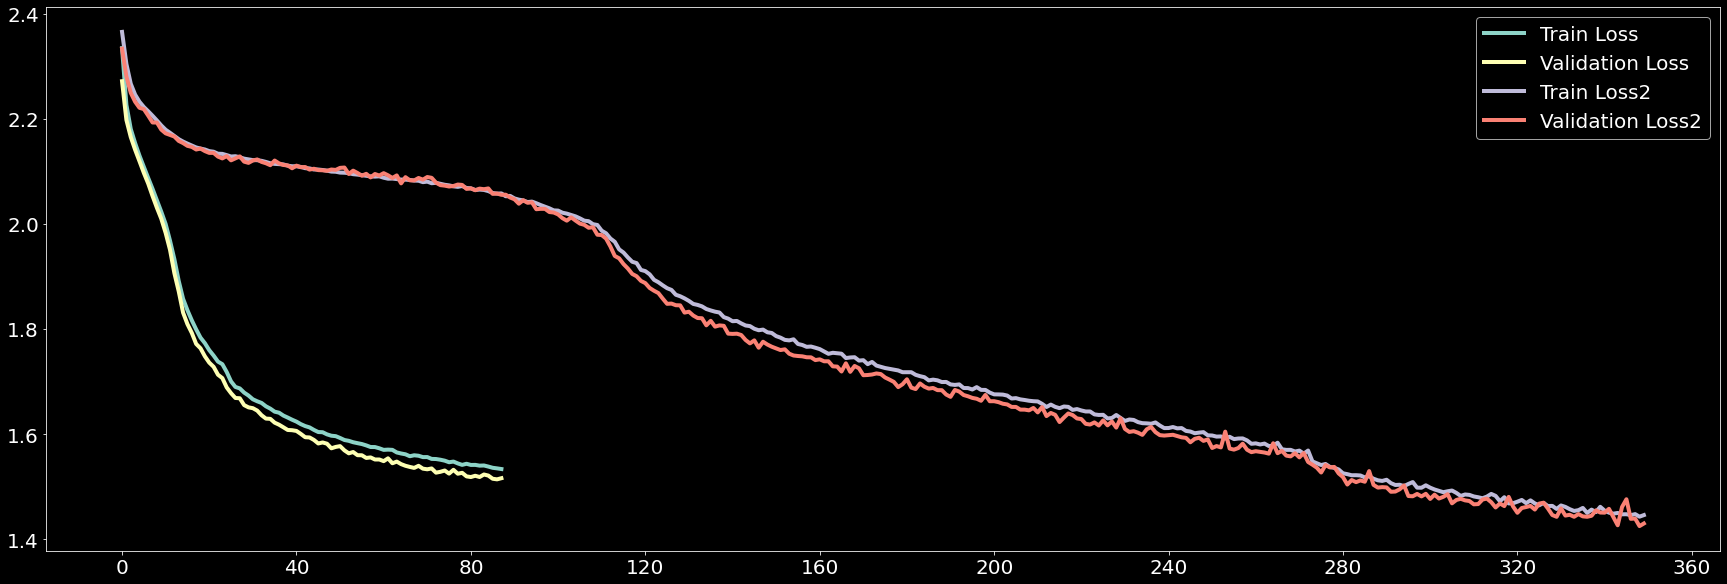

In [4]:
all_subdirs = all_subdirs_of(settings.level_curves_arclength_tuplets_results_dir_path)
latest_subdir = os.path.normpath(max(all_subdirs, key=os.path.getmtime))
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()

results2 = numpy.load(f"C:/deep-signature-data/level-curves/results/tuplets/arclength/2021-01-14-02-42-52/results.npy", allow_pickle=True).item()

epochs = results['epochs']
batch_size = results['batch_size']
train_loss_array = results['train_loss_array']
validation_loss_array = results['validation_loss_array']

train_loss_array2 = results2['train_loss_array']
validation_loss_array2 = results2['validation_loss_array']

epochs_list = numpy.array(range(len(train_loss_array)))
epochs_list2 = numpy.array(range(len(train_loss_array2)))

fig, ax = plt.subplots(1, 1, figsize=(30,10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

ax.plot(epochs_list, train_loss_array, label='Train Loss', linewidth=4.0)
ax.plot(epochs_list, validation_loss_array, label='Validation Loss', linewidth=4.0)

ax.plot(epochs_list2, train_loss_array2, label='Train Loss2', linewidth=4.0)
ax.plot(epochs_list2, validation_loss_array2, label='Validation Loss2', linewidth=4.0)

plt.legend(fontsize=20, title_fontsize=20)

# print(train_loss_array)
# print(validation_loss_array)
plt.show()

# ** TEST MODEL **

[[-6.48616777]]
[[-2.17614975]]
[[-1.49199139]]
[[-4.95153205]]
-----------------------
[[-6.5676093]]
[[-2.62974171]]
[[-1.79221649]]
[[-3.54152843]]
-----------------------
[[-6.5724733]]
[[-2.5652629]]
[[-1.60522467]]
[[-4.98140966]]
-----------------------
[[-6.40433141]]
[[-2.62665594]]
[[-1.597905]]
[[-2.96195582]]
-----------------------
[[-6.52921843]]
[[-2.27132236]]
[[-1.46654479]]
[[-4.41653837]]
-----------------------
[[-6.36294063]]
[[-2.37430311]]
[[-1.41371369]]
[[-4.46225978]]
-----------------------


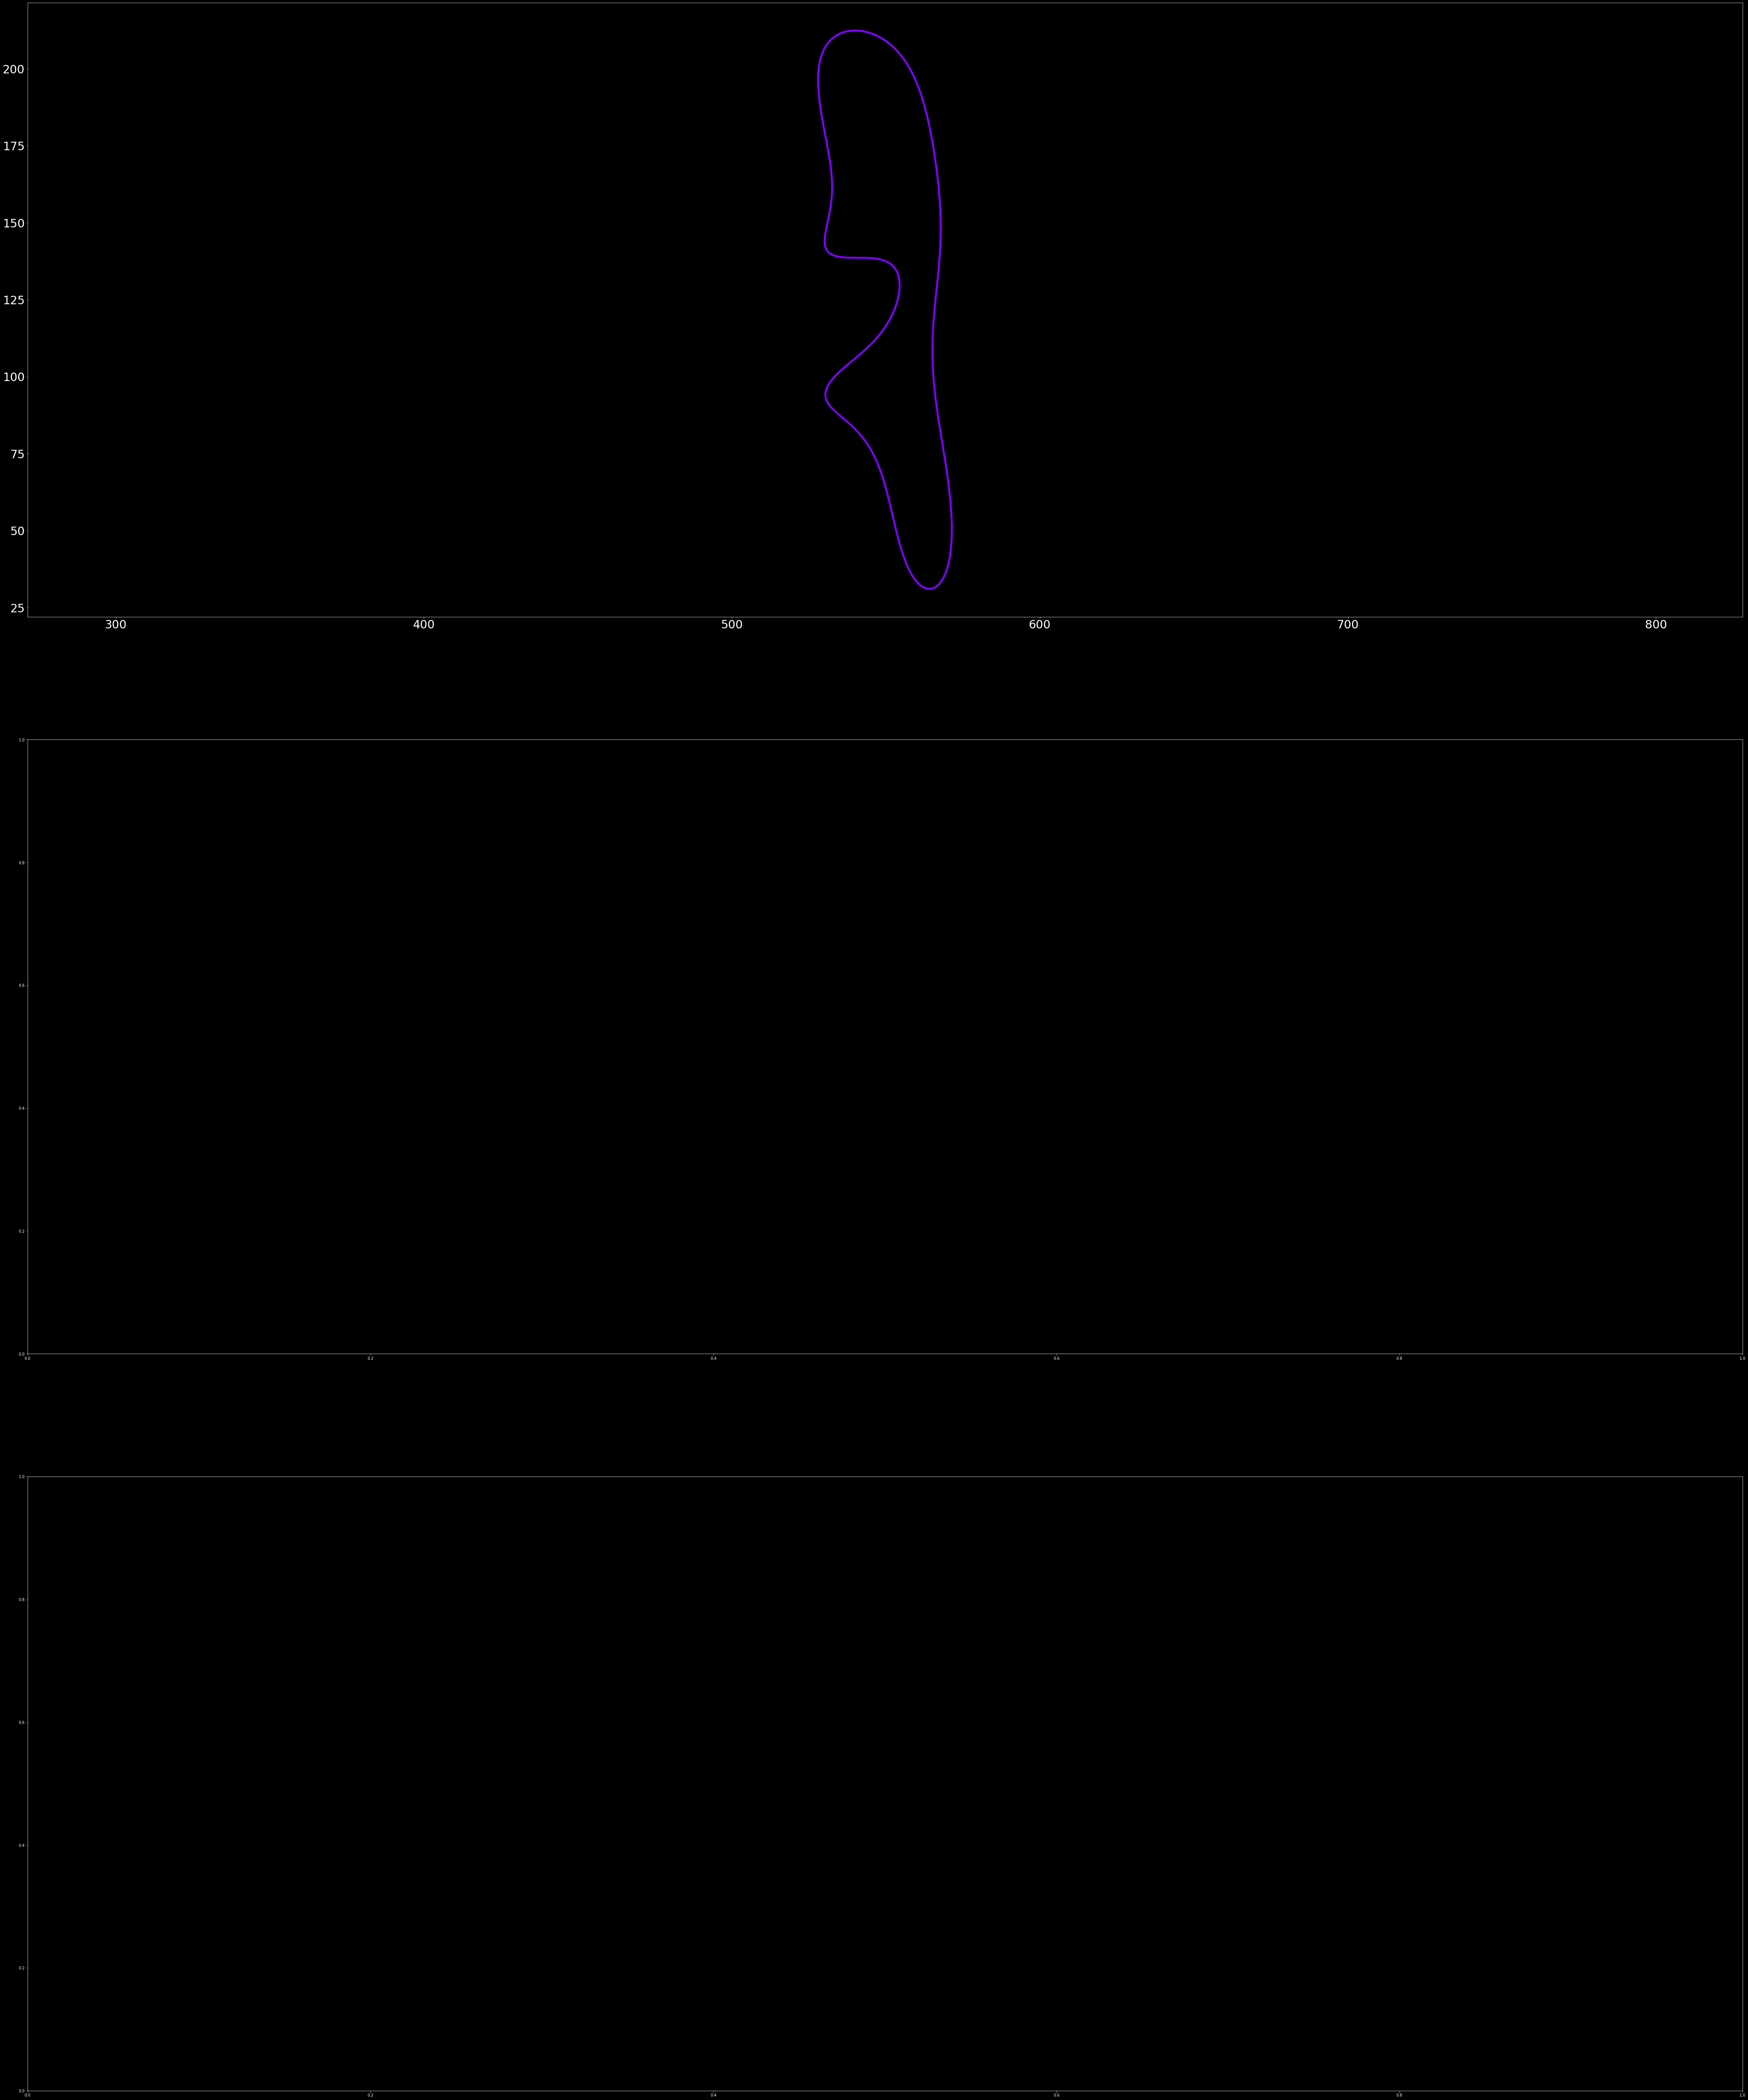

[[-7.82910313]]
[[-4.10704345]]
[[-1.57929802]]
[[-1.02877664]]
-----------------------
[[-7.88855134]]
[[-4.00717124]]
[[-1.91943562]]
[[-1.63913435]]
-----------------------
[[-7.81865083]]
[[-3.67939023]]
[[-1.92053845]]
[[-1.43266256]]
-----------------------
[[-7.83690689]]
[[-4.1585604]]
[[-1.99275609]]
[[-1.76409802]]
-----------------------
[[-8.00164837]]
[[-4.29121669]]
[[-2.23093551]]
[[-1.14776439]]
-----------------------
[[-7.81168102]]
[[-4.08306009]]
[[-2.09196661]]
[[-2.78626407]]
-----------------------


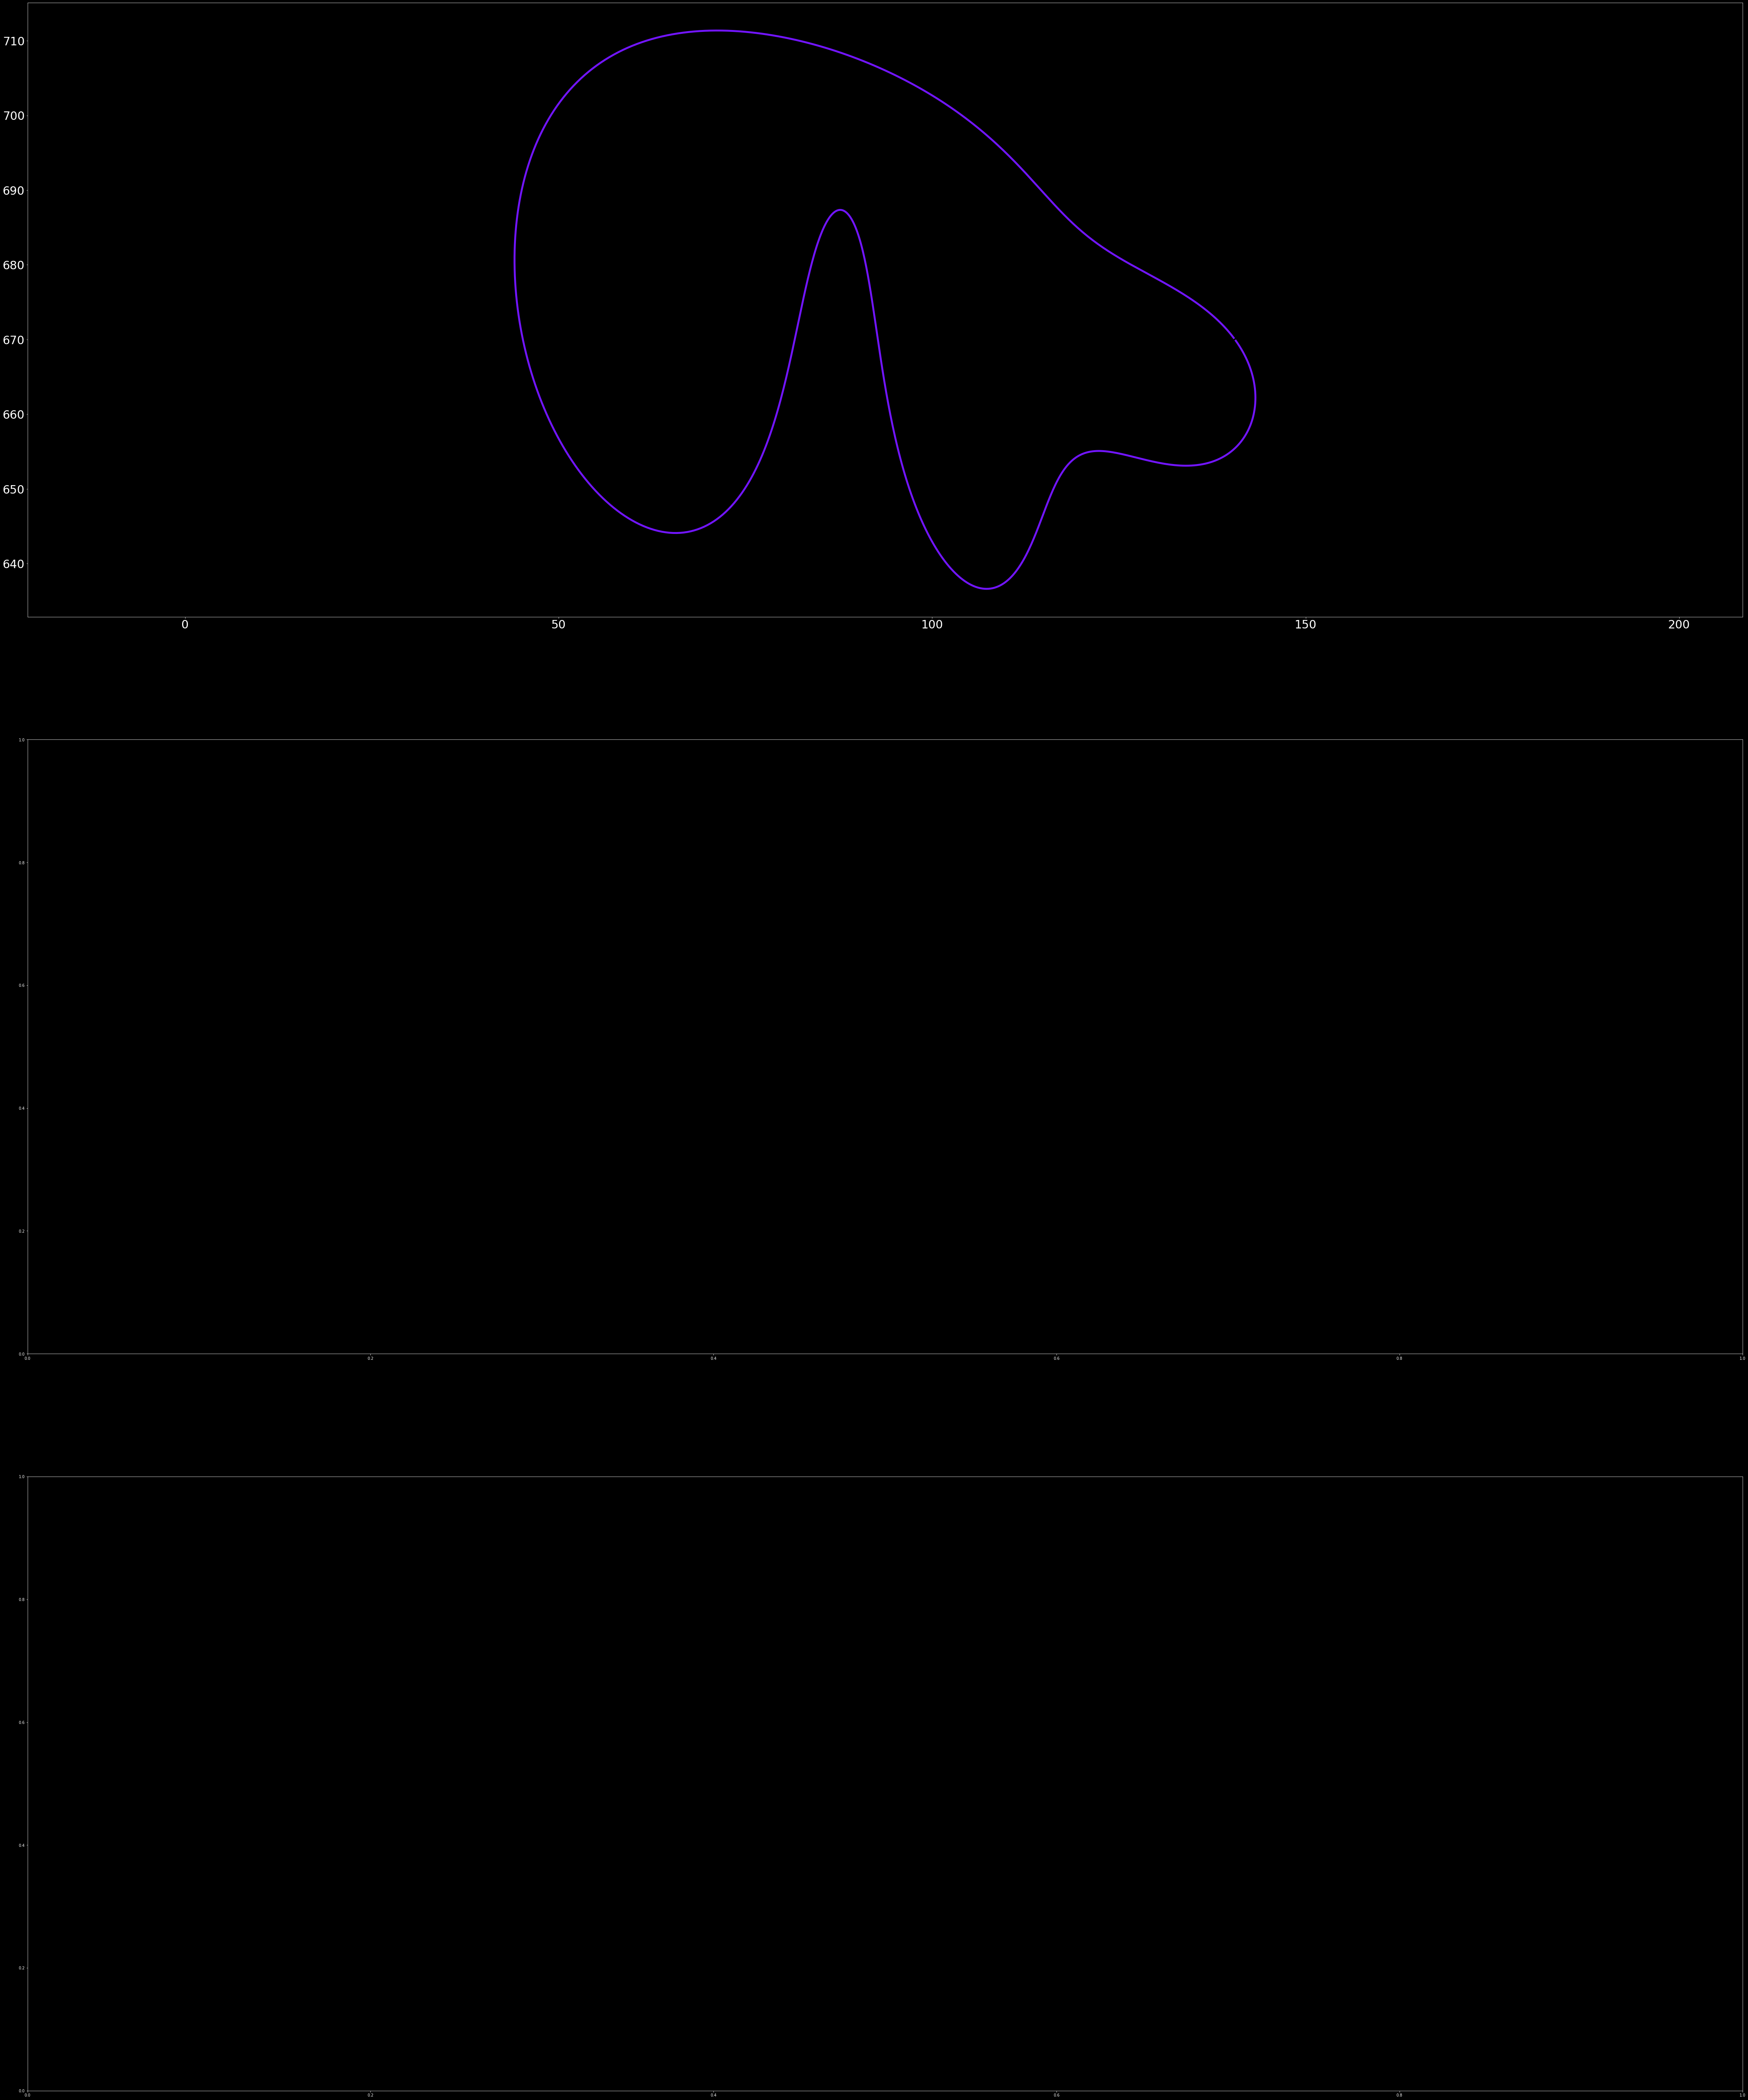

In [6]:
sample_points = 15
supporting_points_count = 15
max_offset = 4
limit = 40
numpy.random.seed(60)

torch.set_default_dtype(torch.float64)
device = torch.device('cuda')
model = DeepSignatureArcLengthNet(sample_points=sample_points).cuda()
model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
# model.load_state_dict(torch.load("C:/deep-signature-data/level-curves/results/tuplets/arclength/2021-01-14-02-42-52/model_56.pt", map_location=device))
model.eval()

curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
numpy.random.shuffle(curves)
curves = curves[:limit]
color_map = plt.get_cmap('rainbow', limit)

for curve_index, curve in enumerate(curves):
    if curve_index == 2:
        break
    fig, ax = plt.subplots(3, 1, figsize=(80,100))
    ax[0].axis('equal')
    for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
        label.set_fontsize(30)

    # for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
    #     label.set_fontsize(30)

    # for label in (ax[2].get_xticklabels() + ax[2].get_yticklabels()):
    #     label.set_fontsize(30)    

    # plot curve
    plot_curve(ax=ax[0], curve=curve, color=color_map(curve_index), linewidth=5)

    # plot predicted curvature
    predicted_arclength = numpy.zeros(curve.shape[0])
    for i in range(curve.shape[0]):
        if i == 6:
            break

        # sample = curve_sampling.sample_curve_section(
        #     curve=curve,
        #     supporting_points_count=supporting_points_count,
        #     start_point_index=i,
        #     end_point_index=i+supporting_points_count)
        # sample = curve_processing.normalize_curve(curve=sample, force_ccw=False, index1=0, index2=1, center_index=0)
        # batch_data = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample).double(), dim=0), dim=0).cuda()
        # with torch.no_grad():
        #     predicted_arclength[i] = torch.squeeze(model(batch_data), dim=0).cpu().detach().numpy()


        # sample1 = curve_sampling.sample_curve_section(
        #     curve=curve,
        #     supporting_points_count=supporting_points_count,
        #     start_point_index=i,
        #     end_point_index=i+supporting_points_count)
        # sample1 = curve_processing.normalize_curve(curve=sample1, force_ccw=False, index1=0, index2=1, center_index=0)
        # batch_data1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample1).double(), dim=0), dim=0).cuda()

        # sample2 = curve_sampling.sample_curve_section(
        #     curve=curve,
        #     supporting_points_count=supporting_points_count,
        #     start_point_index=i,
        #     end_point_index=i+2*supporting_points_count)
        # sample2 = curve_processing.normalize_curve(curve=sample2, force_ccw=False, index1=0, index2=1, center_index=0)
        # batch_data2 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample2).double(), dim=0), dim=0).cuda()

        # sample3 = curve_sampling.sample_curve_section(
        #     curve=curve,
        #     supporting_points_count=supporting_points_count,
        #     start_point_index=i,
        #     end_point_index=i+3*supporting_points_count)
        # sample3 = curve_processing.normalize_curve(curve=sample3, force_ccw=False, index1=0, index2=1, center_index=0)
        # batch_data3 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample3).double(), dim=0), dim=0).cuda()

        # with torch.no_grad():
        #     s1 = torch.squeeze(model(batch_data1), dim=0).cpu().detach().numpy()
        #     s2 = torch.squeeze(model(batch_data2), dim=0).cpu().detach().numpy()
        #     s3 = torch.squeeze(model(batch_data3), dim=0).cpu().detach().numpy()
        #     print(s1)
        #     print(s2)
        #     print(s3)
        #     print('-----------------------')

        for j in range(4):
            sample1 = curve_sampling.sample_curve_section2(
                curve=curve,
                supporting_points_count=supporting_points_count,
                start_point_index=i,
                end_point_index=i+(j+1)*supporting_points_count)
            sample1 = curve_processing.normalize_curve(curve=sample1, force_ccw=True, index1=0, index2=1, center_index=0)
            batch_data1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample1).double(), dim=0), dim=0).cuda()
            with torch.no_grad():
                s1 = torch.squeeze(model(batch_data1), dim=0).cpu().detach().numpy()
                print(s1)
            
        print('-----------------------')

    # plot_curvature(ax=ax[1], curvature=predicted_curvature, color=color_map(curve_index), linewidth=5)

    # plot ground-truth curvature
    # gt_arclength = curve_processing.calculate_arclength(curve=curve)
    # plot_curvature(ax=ax[2], curvature=gt_arclength, color=color_map(curve_index), linewidth=5)

    plt.show()